In [1]:
%matplotlib inline
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
sys.path.append("/home/konajain/code/lobSimulations")
from src.data import dataLoader
import numpy as np
import time
import subprocess
import seaborn as sns

In [2]:
stocks = ['SIRI','BAC', 'INTC','CSCO','ORCL','MSFT','AAPL','ABBV', 'PM','IBM','TSLA','CHTR','AMZN', 'GOOG', 'BKNG']

# Spread 

In [3]:
samplingTime = 60

In [4]:
res = {}

In [5]:
relTick= [16.46, 3.4, 2.19, 1.94, 1.85, 0.77, 0.48, 1.3, 1.22, .72, .36, .25, .06, .08, .05]

In [ ]:
for ric in stocks:
    spreads = []
    if not os.path.exists("/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/"+ric+"_2019-01-02_34200000_57600000_message_10.csv"):
        print('unzipping')
        os.system("/share/apps/p7zip-16.02/bin/7z e /SAN/fca/DRL_HFT_Investigations/"+ric+"_2019-01-01_2020-09-27_10.7z -o/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/ "+ric+"_2019-* -r -y")
    for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
        l = dataLoader.dataLoader(ric, j, j, nlevels = 1, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
        data = l.load()
        if len(data):
            data = data[0]
        else:
            continue
        #try:
        #    data = pd.read_csv( '/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/'+ric+'_'+d.strftime('%Y-%m-%d')+'_12D.csv')   
        #except:
        #    continue
        data['spread'] = data['Ask Price 1'] - data['Bid Price 1']
        sum = data['spread'].sum()
        sumsq = (data['spread']**2).sum()
        count = len(data)
        spreads.append((sum, sumsq, count))
    mean = np.sum([s[0] for s in spreads])/np.sum([s[2] for s in spreads])
    var = (np.sum([s[1] for s in spreads])/np.sum([s[2] for s in spreads])) -mean**2
    res[ric] = (mean, var, (mean**2)/var)
    print(res[ric])

In [6]:
y = [(0.010307495249232301, 3.034281063873427e-06, 35.014705650675474),
    (0.010648574078459915, 6.887332630988553e-06, 16.46386721533631),
    (0.010836480188357695, 9.436874324316081e-06, 12.443665014176108),
    (0.010850488577888676, 1.0979962131749018e-05, 10.72254175070991),
    (0.011404836174042945, 4.391913216184151e-05, 2.9615860276439654),
    (0.0124809545911043, 3.3468979029675024e-05, 4.6542868059133635),
    (0.019677409630387263, 0.00015930443362221358, 2.4305691998522363),
    (0.02295507993686376, 0.0004611119641083069, 1.142749995495752),
    (0.025459922997225912, 0.0007139591261595393, 0.9079058664204626),
    (0.033664693326679346, 0.0008911357563722792, 1.2717608609859425),
    (0.12663653291568963, 0.0074750233275654755, 2.1453861434476003),
    (0.23764760671170376, 0.06564559240908283, 0.860322573126577),
    (0.4680933428375295, 0.06768065189773503, 3.2374300699687204),
    (0.5797509194902905, 0.08311483367394684, 4.04393672937343),
    (1.6238652815692616, 1.1750861980438914, 2.244038315721519)]

In [7]:
res = {}
for r, i in zip(stocks, y):
    res[r] = i

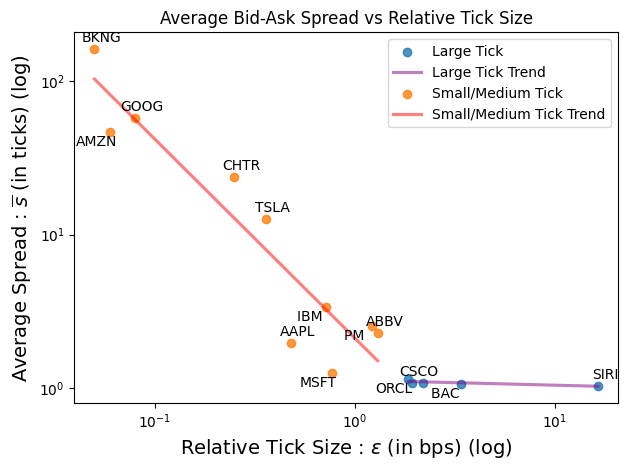

In [9]:
fig = plt.figure()

#plt.scatter(np.array(relTick), [(res[r][1]/res[r][0])**2 for r in stocks]) #, yerr = [10*np.sqrt(res[r][1]) for r in stocks], fmt='o', capsize=5, linestyle='None', color='mediumpurple', ecolor='lightcoral', ms=4.5)
#sns.scatterplot(x=np.log(np.array(relTick)), y=np.log(np.array(maxs)))
p =sns.regplot(x=np.log(np.array(relTick)[:5])/np.log(10), y=np.log(100*np.array(y)[:5][:,0])/np.log(10), ci=False, line_kws={'color':'purple', 'alpha' : 0.5, 'label' : 'Large Tick Trend'}, label = 'Large Tick')
p1 =sns.regplot(x=np.log(np.array(relTick)[5:])/np.log(10), y=np.log(100*np.array(y)[5:][:,0])/np.log(10), ci=False, line_kws={'color':'red', 'alpha' : 0.5, 'label' : 'Small/Medium Tick Trend'}, label = 'Small/Medium Tick')

for i in range(len(stocks)):
    xy = (5,5)
    if stocks[i] in ['AMZN', 'PM', 'IBM', 'BAC', 'MSFT', 'ORCL']:
        xy = (-10, -10)
    if stocks[i] in ['INTC']:
        continue
    plt.annotate(f'{stocks[i]:<4}', (np.log(relTick[i])/np.log(10), np.log(100*np.array(y)[i][0])/np.log(10)), textcoords="offset points", xytext=xy, ha='center', fontsize=10, color='black')
plt.xlabel('Relative Tick Size : $\epsilon$ (in bps) (log)', fontsize=14)
plt.ylabel('Average Spread : $\overline{s}$ (in ticks) (log)', fontsize=14)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim([np.min(np.log(relTick)/np.log(10)) - 0.1, np.max(np.log(relTick)/np.log(10))+0.1])
#plt.ylim([-17.5,0])
plt.title('Average Bid-Ask Spread vs Relative Tick Size')

#plt.minorticks_on()
#plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5)
#plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.3)
locs, labels = plt.xticks()
locs2 = []
for l in locs:
    if int(l) == l:
        locs2.append(l)
plt.xticks(locs2, ['$10^{'+str(int(l))+'}$' for l in locs2])
locs,labels = plt.yticks()
locs2 = []
for l in locs:
    if int(l) == l:
        locs2.append(l)
plt.yticks(locs2, ['$10^{'+str(int(l))+'}$' for l in locs2])
fig.tight_layout()
plt.legend()
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/AvgSpreadVsRelTickSize.png')

In [12]:
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=p1.get_lines()[1].get_xdata(),y=p1.get_lines()[1].get_ydata())
slope

-1.299014311529553

In [13]:
p1.get_lines()[1].get_xdata()

array([-1.30103000e+00, -1.28673734e+00, -1.27244468e+00, -1.25815202e+00,
       -1.24385936e+00, -1.22956670e+00, -1.21527404e+00, -1.20098138e+00,
       -1.18668872e+00, -1.17239605e+00, -1.15810339e+00, -1.14381073e+00,
       -1.12951807e+00, -1.11522541e+00, -1.10093275e+00, -1.08664009e+00,
       -1.07234743e+00, -1.05805477e+00, -1.04376211e+00, -1.02946945e+00,
       -1.01517679e+00, -1.00088413e+00, -9.86591474e-01, -9.72298814e-01,
       -9.58006154e-01, -9.43713494e-01, -9.29420834e-01, -9.15128173e-01,
       -9.00835513e-01, -8.86542853e-01, -8.72250193e-01, -8.57957533e-01,
       -8.43664873e-01, -8.29372213e-01, -8.15079553e-01, -8.00786893e-01,
       -7.86494233e-01, -7.72201573e-01, -7.57908913e-01, -7.43616253e-01,
       -7.29323592e-01, -7.15030932e-01, -7.00738272e-01, -6.86445612e-01,
       -6.72152952e-01, -6.57860292e-01, -6.43567632e-01, -6.29274972e-01,
       -6.14982312e-01, -6.00689652e-01, -5.86396992e-01, -5.72104332e-01,
       -5.57811671e-01, -

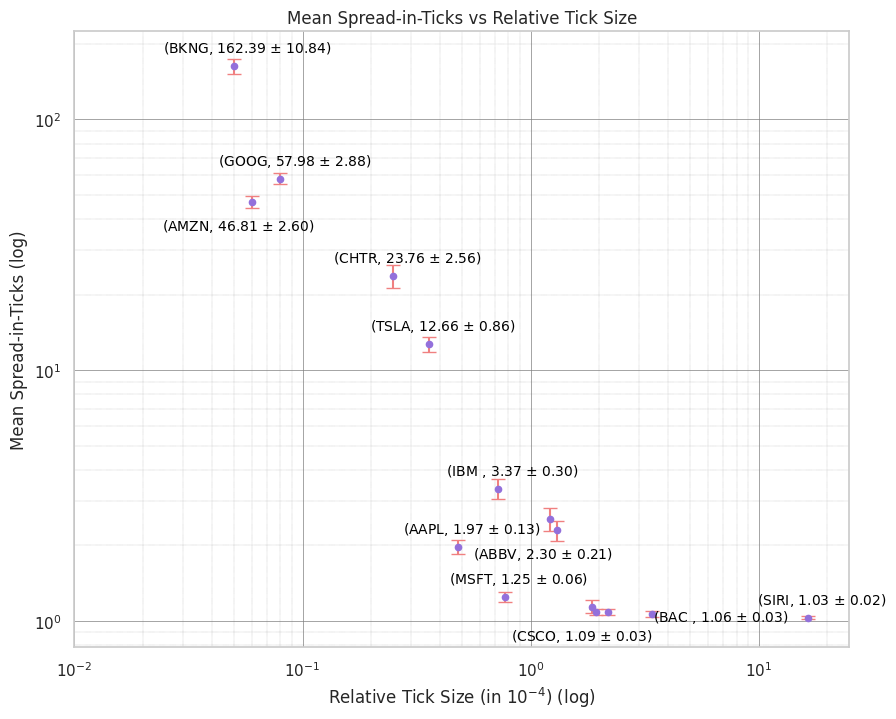

In [106]:


plt.figure(figsize=(10,8))
plt.errorbar(np.array(relTick), [100*res[r][0] for r in stocks], yerr = [10*np.sqrt(res[r][1]) for r in stocks], fmt='o', capsize=5, linestyle='None', color='mediumpurple', ecolor='lightcoral', ms=4.5)
for i in range(len(stocks)):
    xy = (10,10)
    if stocks[i] in ['AMZN', 'CSCO', 'ABBV']:
        xy = (-10, -20)
    elif stocks[i] == 'BAC':
        xy = (50, -5)
    elif stocks[i] in ['INTC', 'ORCL', 'PM']:
        continue
    plt.annotate(f'({stocks[i]:<4}, {100*res[stocks[i]][0]:.2f} $\pm$ {10*np.sqrt(res[stocks[i]][1]):.2f})', (relTick[i], 100*res[stocks[i]][0]), textcoords="offset points", xytext=xy, ha='center', fontsize=10, color='black')
plt.xlabel('Relative Tick Size (in $10^{-4}$) (log)')
plt.ylabel('Mean Spread-in-Ticks (log)')
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01, 25])
plt.title('Mean Spread-in-Ticks vs Relative Tick Size')

plt.minorticks_on()
plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.3)
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/MeanSpreadVsRelTickSize.png')

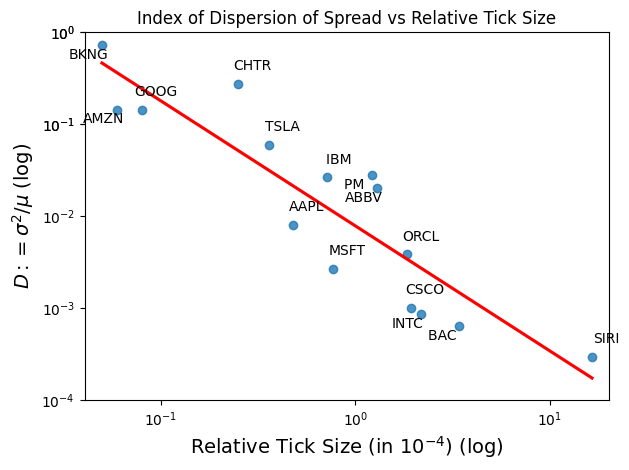

In [8]:
fig = plt.figure()
#plt.scatter(np.array(relTick), [(res[r][1]/res[r][0])**2 for r in stocks]) #, yerr = [10*np.sqrt(res[r][1]) for r in stocks], fmt='o', capsize=5, linestyle='None', color='mediumpurple', ecolor='lightcoral', ms=4.5)
p = sns.regplot(x=np.log(np.array(relTick))/np.log(10), y=[np.log((res[r][1]/res[r][0]))/np.log(10) for r in stocks], ci=False, line_kws={'color':'red'})
for i in range(len(stocks)):
    xy = (10,10)
    if stocks[i] in ['BKNG','AMZN', 'PM','ABBV' ,'INTC', 'BAC']:
        xy = (-10, -10)
    plt.annotate(f'{stocks[i]:<4}', (np.log(relTick[i])/np.log(10), np.log((res[stocks[i]][1]/res[stocks[i]][0]))/np.log(10)), textcoords="offset points", xytext=xy, ha='center', fontsize=10, color='black')
plt.xlabel('Relative Tick Size (in $10^{-4}$) (log)', fontsize=14)
plt.ylabel('$D := \sigma^2 / \mu$ (log)', fontsize=14)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim([-3.2/np.log(10), 3/np.log(10)])

plt.title('Index of Dispersion of Spread vs Relative Tick Size')

#plt.minorticks_on()
#plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5)
#plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.3)
locs, labels = plt.xticks()
locs2 = []
for l in locs:
    if int(l) == l:
        locs2.append(l)
plt.xticks(locs2, ['$10^{'+str(int(l))+'}$' for l in locs2])
locs,labels = plt.yticks()
for l in locs:
    if int(l) == l:
        locs2.append(l)
plt.yticks(locs2, ['$10^{'+str(int(l))+'}$' for l in locs2])
plt.ylim([-4,0])
fig.tight_layout()
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/IoDSpreadVsRelTickSize.png')

In [22]:
locs2

[-1.0, 0.0, 1.0, -4.0, -3.0, -2.0, -1.0, 0.0]

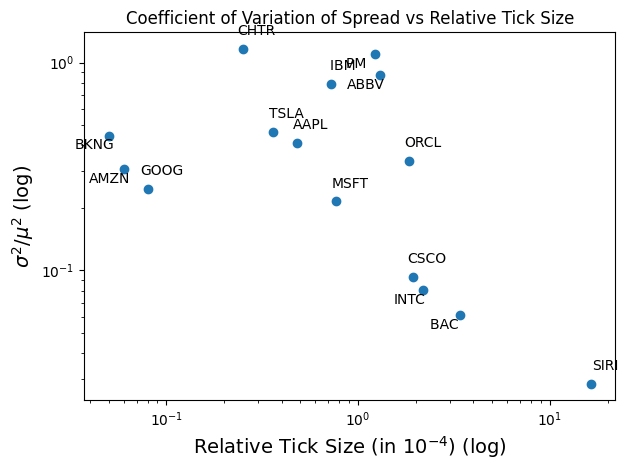

In [13]:
fig = plt.figure()
#plt.scatter(np.array(relTick), [(res[r][1]/res[r][0])**2 for r in stocks]) #, yerr = [10*np.sqrt(res[r][1]) for r in stocks], fmt='o', capsize=5, linestyle='None', color='mediumpurple', ecolor='lightcoral', ms=4.5)
p = plt.scatter(x=np.array(relTick), y=[(res[r][1]/(res[r][0]**2)) for r in stocks])
for i in range(len(stocks)):
    xy = (10,10)
    if stocks[i] in ['BKNG','AMZN', 'PM','ABBV' ,'INTC', 'BAC']:
        xy = (-10, -10)
    plt.annotate(f'{stocks[i]:<4}', ((relTick[i]), res[stocks[i]][1]/(res[stocks[i]][0]**2)), textcoords="offset points", xytext=xy, ha='center', fontsize=10, color='black')
plt.xlabel('Relative Tick Size (in $10^{-4}$) (log)', fontsize=14)
plt.ylabel('$\sigma^2 / \mu^2$ (log)', fontsize=14)
plt.yscale('log')
plt.xscale('log')
#plt.xlim([-3.2/np.log(10), 3/np.log(10)])
#plt.ylim([-17.5/np.log(10),0])
plt.title('Coefficient of Variation of Spread vs Relative Tick Size')

#plt.minorticks_on()
#plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5)
#plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.3)

fig.tight_layout()
plt.savefig('/SAN/fca/Konark_PhD_Experiments/smallTick/CVSpreadVsRelTickSize.png')

In [38]:
import statsmodels.api as sm
x=np.log(np.array(relTick)[6:])/np.log(10)
Y=np.log(100*np.array(y)[6:][:,0])/np.log(10)
X = sm.add_constant(x)
res = sm.OLS(Y, X).fit()
print(res.summary)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f4531a72340>>


In [39]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     56.21
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           0.000138
Time:                        11:56:10   Log-Likelihood:                0.69618
No. Observations:                   9   AIC:                             2.608
Df Residuals:                       7   BIC:                             3.002
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4053      0.123      3.283      0.0

/share/apps/python-3.8.5-shared/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


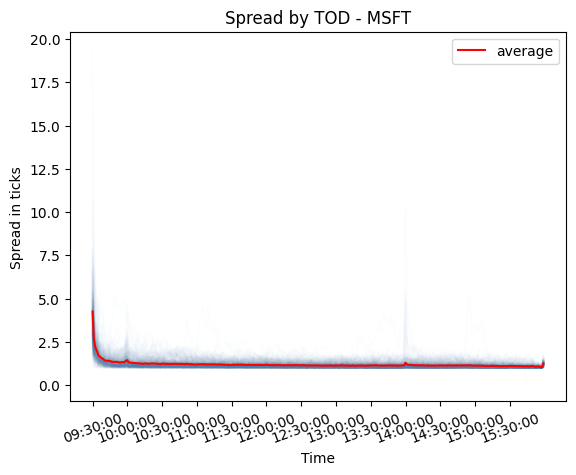

In [137]:
%matplotlib inline
plt.figure()
for s in spreads:
    plt.plot(100*s, alpha = 0.01, color = "steelblue")
plt.plot(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0), color="r", label = "average")
plt.xlabel("Time")
plt.ylabel("Spread in ticks")
plt.legend()
plt.title("Spread by TOD - " + ric)
plt.xticks(ticks = np.arange(0, 23400//samplingTime, 1800//samplingTime), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in 9.5*3600 + samplingTime*np.arange(0, 23400//samplingTime, 1800//samplingTime)], rotation = 20)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SpreadTOD.png")
plt.show()

In [138]:
np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0))

1.1961077595910226

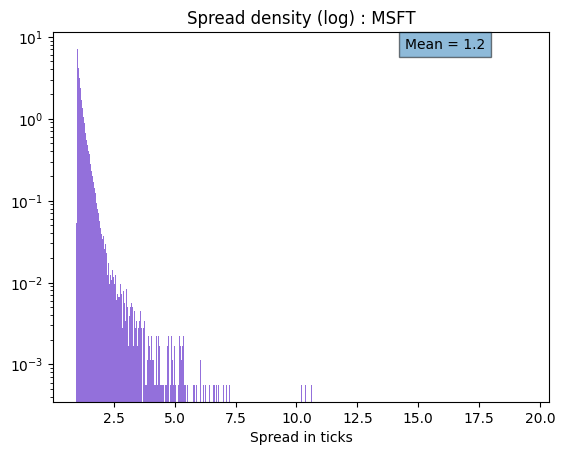

In [157]:
plt.figure()
a = plt.hist(np.ravel(100*np.array([s for s in spreads if len(s) == 390])), bins = 1000, density = True, color="mediumpurple")
plt.xlabel("Ratio")
plt.xlabel("Spread in ticks")
plt.yscale("log")
plt.text(a[1][-1]*0.75, np.max(a[0]), "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))

plt.title("Spread density (log) : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SpreadDistriLog.png")

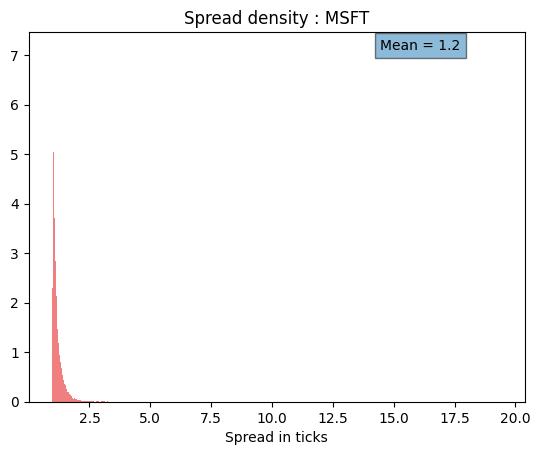

In [156]:
plt.figure()
a =plt.hist(np.ravel(100*np.array([s for s in spreads if len(s) == 390])), bins = 1000, density = True, color="lightcoral")
plt.xlabel("Ratio")
plt.xlabel("Spread in ticks")
plt.text(a[1][-1]*0.75, np.max(a[0]), "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Spread density : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SpreadDistri.png")

In [4]:
import gc
gc.collect()

714

# Shape of the book

In [80]:
# prices = np.arange(0,100)
final_res = {}
final_res_far = {}
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,1,15)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    master_dict, master_dict_far = {}, {}
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    data['total v_a'] = data[["Ask Size " + str(i) for i in range(1,11) ]].sum(axis=1)
    data['total v_b'] = data[["Bid Size " + str(i) for i in range(1,11) ]].sum(axis=1)
    data['mid'] = (data['Ask Price 1'] + data['Bid Price 1'])*0.5
    for i in range(10,0, -1):
        data["Ask Size " + str(i)] = data["Ask Size " + str(i)]/data['total v_a']
        data["Bid Size " + str(i)] = data["Ask Size " + str(i)]/data['total v_b']
        data["Ask Price1 " + str(i)] = np.round(200*(data["Ask Price " + str(i)] - data['mid'])).astype(int)
        data["Bid Price1 " + str(i)] = np.round(200*(data['mid'] - data["Bid Price " + str(i)])).astype(int)
        data["Ask Price2 " + str(i)] = np.round(200*(data["Ask Price " + str(i)] - data["Bid Price 1"])).astype(int)
        data["Bid Price2 " + str(i)] = np.round(200*(data['Ask Price 1'] - data["Bid Price " + str(i)])).astype(int)
        data['tmp'] = data['Ask Size ' + str(i)]*data['timeDiff']
        data_dict = (data.groupby("Ask Price1 " + str(i))['tmp'].sum()/23400).to_dict()
        data_dict_far = (data.groupby("Ask Price2 " + str(i))['tmp'].sum()/23400).to_dict()
        # print(sum(data_dict.values()))
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
        for k, v in data_dict_far.items():
            master_dict_far[k] = master_dict_far.get(k, [])+ [v]
        data['tmp'] = data['Bid Size ' + str(i)]*data['timeDiff']
        data_dict = (data.groupby("Bid Price1 " + str(i))['tmp'].sum()/23400).to_dict()
        data_dict_far = (data.groupby("Bid Price2 " + str(i))['tmp'].sum()/23400).to_dict()
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
        for k, v in data_dict_far.items():
            master_dict_far[k] = master_dict_far.get(k, [])+ [v]
    res_dict = {}
    std_dict = {}
    for k,v in master_dict.items():
        res_dict[k] = np.average(v)
        std_dict[k] = np.std(v)
        final_res[k] = final_res.get(k, [])+ [res_dict[k]]
    res_dict_far = {}
    std_dict_far = {}
    for k,v in master_dict_far.items():
        res_dict_far[k] = np.average(v)
        std_dict_far[k] = np.std(v)
        final_res_far[k] = final_res_far.get(k, [])+ [res_dict_far[k]]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-02_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


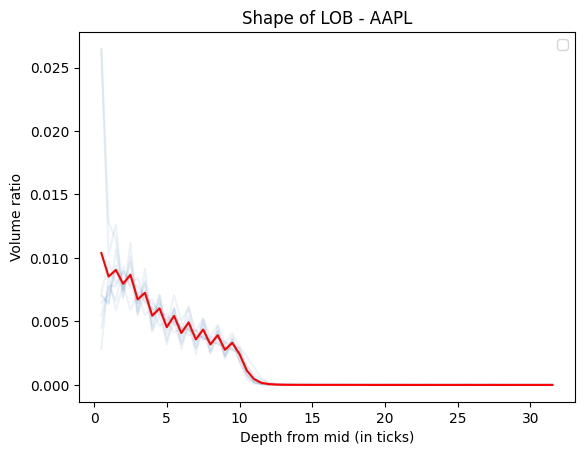

In [81]:
%matplotlib inline
plt.figure()
# plt.plot(np.arange(0,100,2)/2, [(res_dict[k] + res_dict[k+1])/2 for k in range(0,100,2)])
key0 = list(final_res.keys())[0]
for i in range(len(final_res[key0])):
    x, y = [], []
    for k in range(1,250):
        if (final_res.get(k, None) is not None)and(len(final_res.get(k, [])) == len(final_res[key0])):
            x+= [k]
            y+= [final_res[k][i]]
    x = np.array(x)
    if ric in ['SIRI','BAC', 'INTC','CSCO','ORCL','MSFT', 'AAPL','ABBV', 'PM','IBM']:
        x = x[0:-1:2]
        # print(x)
        x = [i for i in x if i <= 20]
        
    plt.plot(x/2, np.array(y)/np.sum(y), alpha = 0.1, color = "steelblue")
Y = np.array([np.average(final_res[k]) for k in x])
plt.plot(x/2, Y/np.sum(Y), color="r")
# plt.fill_between(np.arange(0,100)/2, [np.max([1e-3,res_dict[k] - std_dict[k]]) for k in range(100)], [res_dict[k] + std_dict[k] for k in range(100)], alpha = 0.1, color="b")
# plt.yscale("log")
plt.xlabel("Depth from mid (in ticks)")
plt.ylabel("Volume ratio")
plt.legend()
plt.title("Shape of LOB - " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_Shape.png")

In [77]:
final_res

{19: [0.0028229184102461, 0.0031656222051986336, 0.003810843523965734],
 20: [0.00300607820752692, 0.001938381788785427, 0.001786857801717027],
 21: [0.002203078247160232, 0.0015277126222750536, 0.000773600964005343],
 22: [0.0013924448864127002, 0.0007691834720137487, 0.00018992194643649817],
 23: [0.0004936438033436458, 0.0004215429758422114, 9.392738926566115e-05],
 24: [0.00015029392668017765, 0.00019336977719570678, 2.6841706433056166e-05],
 25: [5.2446867908110844e-05, 9.650064292149385e-05, 2.029560387437313e-05],
 26: [2.6724985159136462e-05, 4.757384271670813e-05, 9.134923207095384e-06],
 27: [1.4839858201579406e-05, 2.711324207972073e-05, 1.1714795177805399e-05],
 28: [1.258256005038108e-05, 1.733918846488537e-05, 9.013626049551808e-06],
 29: [6.665343954515651e-06, 1.4536317924069836e-05, 5.421575211187872e-06],
 30: [7.300944330091587e-06, 9.385936538159413e-06, 3.0674595068359166e-06],
 31: [6.640711283431174e-06, 7.855955171353631e-06, 3.895770922271368e-06],
 32: [7.6906

In [ ]:
# plt.figure()
# # plt.plot(np.arange(0,100,2)/2, [(res_dict[k] + res_dict[k+1])/2 for k in range(0,100,2)])
# for i in range(len(final_res_far[50])-1):
#     plt.plot(np.arange(2,250,2)/2, [final_res_far[k][i] for k in range(2,250,2)], alpha = 0.1, color = "steelblue")
# plt.plot(np.arange(2,250,2)/2, [np.average(final_res_far[k]) for k in range(2,250,2)], color="r")
# # plt.fill_between(np.arange(0,100)/2, [np.max([1e-3,res_dict[k] - std_dict[k]]) for k in range(100)], [res_dict[k] + std_dict[k] for k in range(100)], alpha = 0.1, color="b")
# # plt.yscale("log")
# plt.xlabel("Depth from far touch (in ticks)")
# plt.ylabel("Volume ratio")
# plt.legend()
# plt.title("Shape of LOB - " + ric)
# plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_ShapeFT.png")

In [ ]:
plt.figure()
pctiles = {}
percentiles = [0.1,0.25, 0.5, 0.75, 0.9, 0.99]
for i in range(len(final_res[key0])):
    x, y = [], []
    for k in range(1,250):
        if (final_res.get(k, None) is not None)and(len(final_res.get(k, [])) == len(final_res[key0])):
            x+= [k]
            y+= [final_res[k][i]]
    x = np.array(x)
    vols = np.array(y)
    volsNorm = vols/np.sum(vols)
    cumVols = np.cumsum(volsNorm)
    
    ticks = x/2
    for p in percentiles:
        idx = np.where(cumVols >= p)[0][0]
        # print("Percentile " + str(100*p) + " at " + str(ticks[idx]) + " ticks from mid") 
        pctiles[p] = pctiles.get(p, []) + [ticks[idx]]
# print("Perc Mean Std")
# for p in percentiles:
#     print(100*p, np.round(np.mean(pctiles[p]),1), np.round(np.std(pctiles[p]),2))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

for p in percentiles[:-1]:
    plt.plot(pctiles[p],  label=str(100*p) + "th percentile : " + str(np.round(np.mean(pctiles[p]),1)) +" +- " + str(np.round(np.std(pctiles[p]),2)), alpha = 0.5)
    # plt.text(0, 10*p, )
plt.title("Shape of Book Percentiles Stationarity : "+ ric)
plt.legend()
plt.xlabel("Days")
plt.ylabel("Depth in ticks")
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_ShapeTimeSeries.png")

# Sparse Book

In [ ]:
res, res_distr, wts_distr = {}, {}, {}
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    for i in range(2,11):
        data['tmp'] = data["Ask Price " + str(i)] - data["Ask Price " + str(i-1)] - 0.01
        res[i-1] = res.get(i-1, []) + [np.sum(data['tmp']*data['timeDiff'])/23400]
        res_distr[i-1] = np.append(res_distr.get(i-1, []), data['tmp'])
        wts_distr[i-1] = np.append(wts_distr.get(i-1, []), data['timeDiff'])
        data['tmp'] = data["Bid Price " + str(i)] - data["Bid Price " + str(i-1)] + 0.01
        res[i-1] = res.get(i-1, []) + [np.abs(np.sum(data['tmp']*data['timeDiff'])/23400)]
        res_distr[i-1] = np.append(res_distr.get(i-1, []), np.abs(data['tmp']))
        wts_distr[i-1] = np.append(wts_distr.get(i-1, []), data['timeDiff'])

In [ ]:
print(ric)
for i in range(1,10):
    print("Avg number of empty levels between top + " + str(i-1) + " to top + " + str(i) +" " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for i in range(1,10):
    plt.hist(100*res_distr[i], weights = np.nan_to_num(wts_distr[i]) , bins = np.arange(25), density =True, alpha = 0.2, label ="Top + " +str(i-1) + " to Top + " + str(i)+ " Median : " + str(np.round(100*np.median(res[i]),2))+" Mean : " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))
# plt.ylabel("Ratio")
plt.xlabel("Number of Empty levels")
plt.legend()
# plt.xscale("log")
# plt.yscale("log")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Empty Levels density : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SparsityDistri.png")

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for i in range(1,10):
    plt.hist(100*res_distr[i], weights = np.nan_to_num(wts_distr[i]), bins = np.arange(200), density = True, alpha = 0.2, label ="Top + " +str(i-1) + " to Top + " + str(i)+ " Median : " + str(np.round(100*np.median(res[i]),2))+" Mean : " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))
# plt.ylabel("Ratio")
plt.xlabel("Number of Empty levels")
plt.legend()
# plt.xscale("log")
plt.yscale("log")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Empty Levels density : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SparsityDistriLog.png")

In [ ]:
plt.figure()
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for i in range(1,10):
    plt.plot(res[i], alpha = 0.5, label ="Top + " +str(i-1) + " to Top + " + str(i)+" Mean : " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))
plt.xlabel("Days")
plt.ylabel("Number of Empty levels")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Empty Levels TimeSeries : " + ric)
plt.legend()
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SparsityTimeSeries.png")

# Volume at best vs ADV

In [ ]:
bests, advs = [], []
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    adv = data.loc[data['Type'] == 4]['Size'].sum()
    best = ((data['Ask Size 1']+data['Bid Size 1'])*data['timeDiff']).sum()
    bests.append(best)
    advs.append(adv)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
ax1.plot(np.array(bests)/2, alpha = 0.5, label ="Best Volume (both sides)")
ax1.plot(advs, alpha = 0.5, label = "Daily Traded Volume")
ax2.plot(np.array(bests)/(2*np.array(advs)), color = "r", label = "Volume at Best/ADV")
ax2.axhline(np.array(bests).sum()/(2*np.array(advs).sum()), 0, len(bests), ls = "-.", color="r",  label ="Average")
ax2.set_ylabel("Ratio", color="r")
ax1.set_xlabel("Days")
ax1.set_ylabel("Shares")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
ax1.set_title("Best Volume/ ADV TimeSeries : " + ric)
ax1.legend()
ax2.legend()
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_BestVolumeADVTimeSeries.png")

# MOs vs number and levels of queue depletions

In [5]:
res = {}
for ric in ['CSCO' ,'CHTR']:
    ratios_day = []
    ratios , wts = [], []
    for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,3,31)):
        if j == dt.date(2019,1,9): continue
        l = dataLoader.dataLoader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
        data = l.load()
        if len(data):
            data = data[0]
        else:
            continue
        data['timeDiff'] = data['Time'].diff()
        data_trade = data.loc[data['Type'] == 4]
        trades = data_trade['Size']
        best = data_trade['Ask Size 1']*(1 - data_trade['TradeDirection'])/2 +data_trade['Bid Size 1']*(data_trade['TradeDirection'] + 1)/2
        ratios_day.append(((trades/best)*data_trade['timeDiff']).sum()/23400)
        ratios = np.append(ratios, (trades/best).values)
        wts = np.append(wts, data_trade['timeDiff'].values)
    res[ric] = (ratios, wts, ratios_day)

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-02_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-16_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-17_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-23_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-30_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-01-31_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-26_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-02-28_34200000_57600000_message_10.csv
/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-04_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-06_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-12_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-13_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-14_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-15_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-20_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-21_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-25_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CSCO_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-02_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-16_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-17_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-22_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-23_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-24_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-30_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-01-31_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-22_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-02-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-01_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-05_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-06_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-07_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-08_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-12_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-13_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-14_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-15_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-18_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-19_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-20_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-21_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-22_34200000_57600000_message_10.csv


/tmp/ipykernel_63640/3916119513.py:8: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-25_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-26_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-27_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-28_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/CHTR_2019-03-29_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/src/data/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


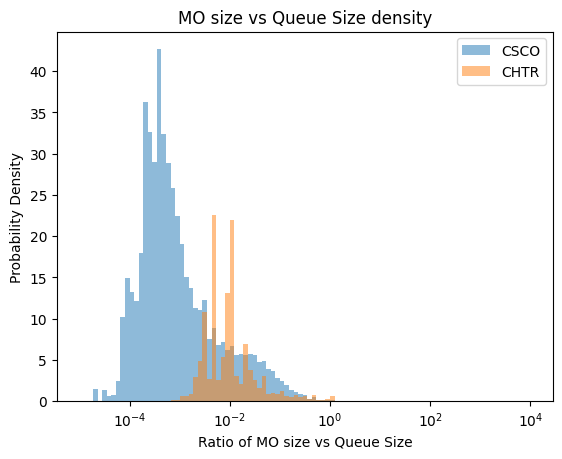

In [21]:
plt.figure()
for k, v in res.items():
    ratios, wts, ratios_day = v
    plt.hist(ratios, weights = np.nan_to_num(wts), bins = np.power(10, np.linspace(-5,4, num  = 100)),  density = True, alpha=0.5, label= k)
    plt.ylabel("Probability Density")
    plt.xlabel("Ratio of MO size vs Queue Size")
    #plt.text(1e2, 0.5, k + " Mean = " + str(np.round(np.average(ratios_day),2)), bbox=dict(alpha=0.5))
    #plt.text(1e2, 15, k + " Median = " + str(np.round(np.median(ratios),2)), bbox=dict(alpha=0.5))
plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.title("MO size vs Queue Size density")
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/CSCOCHTR_EDA_MORatioDistri.png")

# Arrival rates wrt mid

In [8]:
final_res= {}
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    master_dict = {}
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    data['mid'] = (data['Ask Price 1'] + data['Bid Price 1'])*0.5
    for i in range(10,0, -1):
        data["Ask Price1 " + str(i)] = np.round(200*(data["Ask Price " + str(i)] - data['mid'])).astype(int)
        data["Bid Price1 " + str(i)] = np.round(200*(data['mid'] - data["Bid Price " + str(i)])).astype(int)
        data_dict = (data.groupby("Ask Price1 " + str(i))['Time'].count()).to_dict()
        # print(sum(data_dict.values()))
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
        data_dict = (data.groupby("Bid Price1 " + str(i))['Time'].count()).to_dict()
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
    for k,v in master_dict.items():
        final_res[k] = final_res.get(k, [])+ [np.sum(master_dict[k])/23400]
for k,v in final_res.items():
    final_res[k] = np.mean(v)

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-02_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


In [10]:
for k,v in final_res.items():
    final_res[k] = np.mean(v)

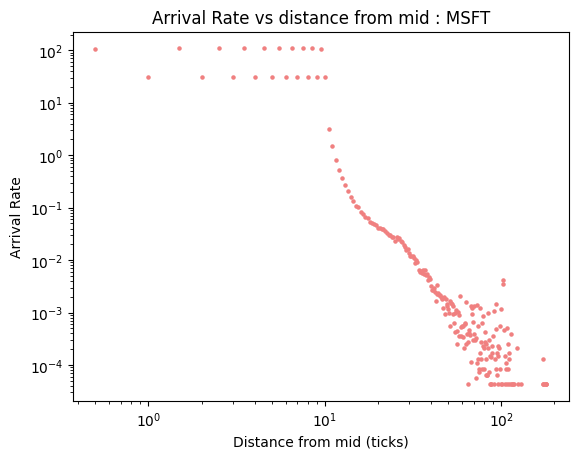

In [21]:
%matplotlib inline
plt.figure()
plt.scatter([i/2 for i in list(final_res.keys())], list(final_res.values()), s= 5, c= "lightcoral")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance from mid (ticks)")
plt.ylabel("Arrival Rate")
plt.title("Arrival Rate vs distance from mid : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_ArrivalRateVsDistanceFromMid.png")

# price depletions by MO

In [4]:
if True:
    wts , chgs = [], []
    for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,1,4)):
        if j == dt.date(2019,1,9): continue
        l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
        data = l.load()
        if len(data):
            data = data[0]
        else:
            continue
        data['timeDiff'] = data['Time'].diff()
        data['Ask Price change' ] = data['Ask Price 1'] - data['Ask Price 1'].shift(1)
        data['Bid Price change' ] = data['Bid Price 1'] - data['Bid Price 1'].shift(1)
        data_trade = data.loc[data['Type'] == 4]
        wts = np.append(wts, data.timeDiff.values)
        chgs = np.append(chgs, (data_trade['Ask Price change'] + data['Bid Price change']).values)
    

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-02_34200000_57600000_message_10.csv


/tmp/ipykernel_37776/1884598335.py:6: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/INTC_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000
